In [1]:
import math
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import scipy.cluster.hierarchy as sch
import itertools
import GPy
import dill
import csv
import folium
import seaborn as sns
import networkx as nx


from datetime import datetime
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from IPython.display import display
from scipy import stats
from scipy.stats import norm, percentileofscore
from scipy import interpolate
from scipy.spatial.distance import squareform
from statistics import mean 
from mpl_toolkits.basemap import Basemap
from folium import plugins

### Loading inferred data

In [2]:
ds = pd.read_csv("data/predictions/ds_gaussian_clean.csv")
ds = ds.drop(['Unnamed: 0'], axis=1)

### Loading GSIM data

In [3]:
'''
This function loads the meta data, monhtly, yearly and seasonal data from the GSIM dataset for a gsim number
To each dataframe the gsim number is added for further identification.
Colum names are cleaned and a list of all dataframes is finally returned
'''
def loadTimeseries (series_name): 
    meta = gsim_metadata.loc[gsim_metadata['gsim.no'] == series_name]
    monthly = pd.read_csv("data/GSIM_indices/TIMESERIES/monthly/"+series_name+".mon", sep=',' '\\t', skiprows=lambda x : x < 21, engine='python',)
    yearly = pd.read_csv("data/GSIM_indices/TIMESERIES/yearly/"+series_name+".year", sep=',' '\\t', skiprows=lambda x : x < 21, engine='python',)
    seasonal = pd.read_csv("data/GSIM_indices/TIMESERIES/seasonal/"+series_name+".seas", sep=',' '\\t', skiprows=lambda x : x < 21, engine='python',)
    monthly['gsim.no'] = series_name
    yearly['gsim.no'] = series_name
    seasonal['gsim.no'] = series_name
    monthly.columns, yearly.columns, seasonal.columns = monthly.columns.str.replace('"', ''), yearly.columns.str.replace('"', ''), seasonal.columns.str.replace('"', '')
    return [meta, monthly, yearly, seasonal]

In [4]:
'''
Transforms the last date of measurment for a season priveded in the gsim dataset as the feature date
As the seasonal gsim dataset stores the last date of measurement the last day of measurement of season DJF is in February, MAM in May and so on 
'''
def determimeSeason(date):
    endMonth = pd.to_datetime(date).month
    switcher = {
        2: "DJF",
        5: "MAM",
        8: "JJA",
        11: "SON"
    }
    return switcher.get(endMonth, "undefined")

In [5]:
# Loading the GSIM_metadata_Archive
gsim_metadata = pd.read_csv("data/GSIM_metadata/GSIM_catalog/GSIM_metadata.csv", sep=",")


# Selecting all the dataframes for South America by 2 Letter Country Code
southamerica2letterCC = ['AR', 'BO', 'BR', 'CL', 'CO', 'EC', 'FK', 'GF', 'GY', 'PY', 'PE', 'SR', 'UY', 'VE']

stations_of_interest = pd.Series()
for country in southamerica2letterCC: 
    stations_of_interest = stations_of_interest.append(gsim_metadata.loc[gsim_metadata['country'] == country]['gsim.no'], ignore_index=True)
        
    
# Initialisation of the empty lists where we store the dataframes: datatype: list of dataframes
df_yearly = []
df_monthly = []
df_seasonal = []
df_meta = []

# For each station in South America we load the meta, yearly, seasonal and monthly dataset
for station in stations_of_interest:
    
    series = loadTimeseries(station)
    df_meta.append(series[0])
    df_monthly.append(series[1])
    df_yearly.append(series[2])
    df_seasonal.append(series[3])

    
        
# For each dataframe in our monthly dataset we add a column that stores each the year and the month for a given measurement
for df in df_monthly: 
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['date'] = pd.to_datetime(df['date']).dt.date

    
# For each dataframe in our yearly dataset we add a column that stores the year for a given measurement
for df in df_yearly: 
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['date'] = pd.to_datetime(df['date']).dt.date


# For each dataframe in our seasonal dataset we add a column that stores the year and the season of the measurment. 
# Note that for the season DJF, the year is year of the months January and February is stored. 
for df in df_seasonal: 
    df['date'] = pd.to_datetime(df['date']).dt.date
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['season'] = [determimeSeason(date) for date in df['date']]
    
    
# Merge the list of metadataframes into one single dataframe, as for each station only one row of metadat exists we can merge them into one single dataframe
for index,meta in enumerate(df_meta):
    if index == 0:
        ds_meta = meta
    else: 
        ds_meta = ds_meta.append(meta, ignore_index = True)

## Similarity Analysis

In [6]:
'''
For a list of gsimNumbers the respective coordinates are stored in the format of [longitude, latitude] for each entry
@param list of gsimNumbers
@return list of coordinates
'''
def getCoordinates(gsimNumbers):
    coordinates = []
    for number in gsimNumbers: 
        coords = [ds_meta.loc[ds_meta['gsim.no'] == number]['longitude'].values[0], ds_meta.loc[ds_meta['gsim.no'] == number]['latitude'].values[0]]
        coordinates.append(coords)
        
    return coordinates

In [7]:
'''
For a given timespan those stations are filtered who have at lest one of its top n peak river discharge values during the active
timespan of the given ENSO eventm, using the inferred dataset. 
@param  number of dimensions n, 
        timespan during which the ENSO event was active as a list of strings, 
        a dataset as a list of pandas.dataframes
@return a list of unique gsimNumbers
'''
def getTopNStationsInferred (n, activeENSOTime, dataset = ds):
    gsimNumbers = []
    dates = [date.split('-')[0] + '-' + date.split('-')[1] for date in dataset.columns[:-1]]
    for index, row in dataset.iterrows():
        values = row[:-1].values
        values = np.nan_to_num(values)  # if there are any nan values they will be set to zero and therfore not considered
        maxIndex = np.argsort(values)[-n:]
        for index in maxIndex:
            dateOfMaxDischarge = dates[index]
            if dateOfMaxDischarge in activeENSOTime:
                gsimNumbers.append(row[-1])
            
    return list(set(gsimNumbers))

In [8]:
'''
For a given timespan those stations are filtered who have at lest one of its top n peak river discharge values during the active
timespan of the given ENSO eventm, using the raw GSIM dataset. 
@param  number of dimensions n, 
        timespan during which the ENSO event was active as a list of strings, 
@return a list of unique gsimNumbers
'''
def getTopNStationsRaw (n, activeENSOTime):
    gsimNumbers = []
    for df in df_monthly:
        dates = [str(date).split('-')[0] + '-' + str(date).split('-')[1] for date in df['date']]
        values = df['MEAN'].copy().to_numpy()
        values = np.nan_to_num(values)  # if there are any nan values they will be set to zero and therfore not considered
        maxIndex = np.argsort(values)[~np.isnan(values)][-n:]
        for index in maxIndex:
            dateOfMaxDischarge = dates[index]
            if dateOfMaxDischarge in activeENSOTime:
                gsimNumbers.append(df['gsim.no'].any())
            
    return list(set(gsimNumbers))

In [9]:
'''
Computation of the Jaccard distance for two sets
@param  A: set of stations
        B: set of stations
'''
def jaccardDistance(A,B): 
    cutSet = [element for element in A if element in B ]
    return 1 - (len(cutSet)/(len(set(A+B))))

###### Similarity Analysis for El Niño

In [10]:
# Those durations are from the official definition of ENSO events of more than +/- 0.5 of the Niño 3.4 index for 3 consecutive months:
# data taken from https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

# 1965/66 occured from April 1965 until May 1966
activeElNinoTime_1965_66 = ['1965-04','1965-05','1965-06','1965-07','1965-08','1965-09','1965-10','1965-11','1965-12','1966-01','1966-02','1966-03','1966-04']


# 1972/73 occured from April 1972 until April 1973
activeElNinoTime_1972_73 = ['1972-04','1972-05','1972-06','1972-07','1972-08','1972-09','1972-10','1972-11','1972-12','1973-01', '1973-02', '1973-03', '1973-04']


# 1982/83 occured from March 1982 until July 1983
activeElNinoTime_1982_83 = ['1982-03','1982-04','1982-05','1982-06','1982-07','1982-08','1982-09','1982-10','1982-11','1982-12','1983-01', '1983-02','1983-03','1983-04','1983-05','1983-06','1983-07']


# 1997/98 occured from April 1997 until June 1998
activeElNinoTime_1997_98 = ['1997-04','1997-05','1997-06','1997-07','1997-08','1997-09','1997-10','1997-11','1997-12','1998-01','1998-02','1998-03','1998-04','1998-05','1998-06']


# 2015/16 occured from Sept 2014 until May 2016
activeElNinoTime_2015_16 = ['2014-09','2014-10','2014-11','2014-12','2015-01','2015-02','2015-03','2015-04','2015-05','2015-06','2015-07','2015-08','2015-09','2015-10','2015-11','2015-12','2016-01','2016-02','2016-03','2016-04','2016-05']


In [11]:
n = 10

gsim1965_66 = getTopNStationsInferred(n, activeElNinoTime_1965_66)
gsim1972_73 = getTopNStationsInferred(n, activeElNinoTime_1972_73)
gsim1982_83 = getTopNStationsInferred(n, activeElNinoTime_1982_83)
gsim1997_98 = getTopNStationsInferred(n, activeElNinoTime_1997_98)
gsim2015_16 = getTopNStationsInferred(n, activeElNinoTime_2015_16)

gsimNumsDuringAllElNinos = [gsim1965_66, gsim1972_73, gsim1982_83, gsim1997_98, gsim2015_16 ]

In [12]:
'''
Computation of the similarity matrix for either La Ninas or El Ninos, where for each combination of events the Jaccard distance is computed and saved in the matrix 
@param  gsimNumsOfAllEvents - list of lists of strings: each list contains the gsimNumbers of the stations affected during its timespan.
        labels - list of strings: the labels for each column and row entry 
@return numpy.matrix the matrix with the respective distance values for each combination of events. 
'''

def computeSimilarityMatrix(gsimNumsOfAllEvents,labels):
    similarityMatrix = np.zeros((5,5))
    for index_i, event_i in enumerate(gsimNumsOfAllEvents): 
        for index_j, event_j in enumerate(gsimNumsOfAllEvents): 
            similarityMatrix[index_i, index_j] = jaccardDistance(event_i, event_j)

    similarityDf = pd.DataFrame(similarityMatrix, columns=labels, index=labels)
    return similarityDf

In [13]:
elNinoSimilarityDf = computeSimilarityMatrix(gsimNumsDuringAllElNinos,['1965/66', '1972/73', '1982/83', '1997/98', '2015/16'])
elNinoSimilarityDf

,1965/66,1972/73,1982/83,1997/98,2015/16
1965/66,0.000000,0.904110,0.819791,0.912791,0.892308
1972/73,0.904110,0.000000,0.910397,0.877953,0.903581
1982/83,0.819791,0.910397,0.000000,0.806947,0.865217
1997/98,0.912791,0.877953,0.806947,0.000000,0.794239
2015/16,0.892308,0.903581,0.865217,0.794239,0.000000


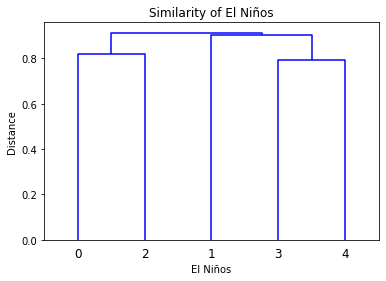

[]

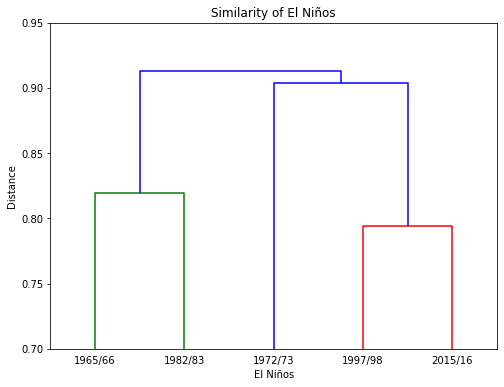

In [14]:
# In this cell we take the upper triangle of the distance matrix via squareform, which will be the input for our linkage function
# this links ElNions events whose impact pattern of stations are similar
# after linking the El Ninos we plot the dendrogram to get a more visual understanding of the process


y = squareform(elNinoSimilarityDf)
linkage = sch.linkage(y, method='complete')
dn = sch.dendrogram(linkage)
plt.title('Similarity of El Niños')
plt.xlabel('El Niños')
plt.ylabel('Distance')
plt.show()


fig = plt.figure(figsize=(8, 6))
y = squareform(elNinoSimilarityDf)
linkage = sch.linkage(y, method='complete')
dn2 = sch.dendrogram(linkage, color_threshold = 0.82)
plt.title('Similarity of El Niños')
plt.xlabel('El Niños')
plt.ylabel('Distance')
plt.ylim((0.70, 0.95))

## TODO check labels ....
plt.xticks([5,15,25,35,45],[ '1965/66', '1982/83', '1972/73', '1997/98', '2015/16'],  fontsize=10)
plt.plot()
#plt.savefig("plots/dendrogramENTop10.svg")


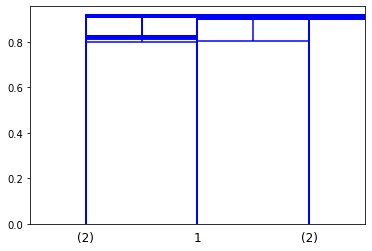

In [15]:
# Warning: This might take some time!

'''
To check the robustness of the similarity analysis we perform crossValidation on this analysis 
5 % of the samples are removed and the similarity analysis is performed to check if this impacts our results
'''
percentageToRemove = 0.05
crossValidMatrix = np.zeros((5,5))
dendrogramDf = pd.DataFrame(crossValidMatrix, columns=[0,1,2,3,4], index=[0,1,2,3,4])
amountOfSamplesToRemove = int (percentageToRemove * ds.shape[0]) # Remove 5 percent of the samples
topN = 10

for i in range (100): 
    ds_sub = ds.copy()
    drop_indices = np.random.choice(ds_sub.index, amountOfSamplesToRemove, replace=False)
    df_subset = ds_sub.drop(drop_indices)
    gsim1965_66 = getTopNStationsInferred(topN, activeElNinoTime_1965_66, df_subset)
    gsim1972_73 = getTopNStationsInferred(topN, activeElNinoTime_1972_73, df_subset)
    gsim1982_83 = getTopNStationsInferred(topN, activeElNinoTime_1982_83, df_subset)
    gsim1997_98 = getTopNStationsInferred(topN, activeElNinoTime_1997_98, df_subset)
    gsim2015_16 = getTopNStationsInferred(topN, activeElNinoTime_2015_16, df_subset)

    gsimNumsDuringAllElNinos = [gsim1965_66, gsim1972_73, gsim1982_83, gsim1997_98, gsim2015_16 ]
    similarityMatrixElNino = np.zeros((5,5))
    for index_i, elNino_i in enumerate(gsimNumsDuringAllElNinos): 
        for index_j, elNino_j in enumerate(gsimNumsDuringAllElNinos): 
            similarityMatrixElNino[index_i, index_j] = jaccardDistance(elNino_i, elNino_j)

    elNinoSimilarityDf = pd.DataFrame(similarityMatrixElNino, columns=['1965/66', '1972/73', '1982/83', '1997/98', '2015/16'], index=['1965/66', '1972/73', '1982/83', '1997/98', '2015/16'])
    
    y = squareform(elNinoSimilarityDf)
    linkage = sch.linkage(y, method='complete')
    dn1 = sch.dendrogram(linkage)
    dn2 = sch.dendrogram(linkage, color_threshold = 0.90, truncate_mode='lastp', p=3)
    
    index = 0
    for group in dn2['ivl']:
        if group == '1':
            n1 = int (dn1['ivl'][index])
            crossValidMatrix[n1][n1] += 1
            index += 1
        
        
        elif group == '(2)':
            n1 = int (dn1['ivl'][index]) 
            n2 = int (dn1['ivl'][index +1])
            crossValidMatrix[n1][n2] += 1
            crossValidMatrix[n2][n1] += 1
            index += 2
        elif group == '(3)':
            n1 = int (dn1['ivl'][index]) 
            n2 = int (dn1['ivl'][index +1])
            n3 = int (dn1['ivl'][index +2])
            crossValidMatrix[n1][n2] += 1
            crossValidMatrix[n1][n3] += 1
            crossValidMatrix[n2][n1] += 1
            crossValidMatrix[n2][n3] += 1
            crossValidMatrix[n3][n1] += 1
            crossValidMatrix[n3][n2] += 1
            index += 3
        else:
            continue


In [16]:
crossValidMatrix

array([[  0.,   0., 100.,   0.,   0.],
       [  0., 100.,   0.,   0.,   0.],
       [100.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 100.],
       [  0.,   0.,   0., 100.,   0.]])

 C:\Users\marku\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning:
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.


[]

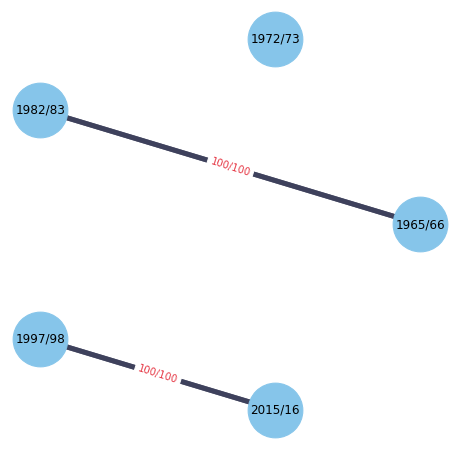

In [17]:
# The previously computed crossValidationMatrix is now used as a adjacency matrix to plot a weighted, undirected graph. 
# This graph is generated in this cell. 

# Note the values are written by hand on the edges 
# As the crossvalidation process is based on random sampling this crossValidationMatrix might look different for multiple runs
# Therefore the edge weights might differ as well and need to be adjusted manually


ENs = ['1965/66', '1972/73', '1982/83', '1997/98', '2015/16']
weights=[]

plt.figure(figsize=(8,8)) 
G = nx.MultiGraph()
G.add_nodes_from(ENs)
for indexI, row in enumerate(crossValidMatrix): 
    for indexJ, value in enumerate(row):
        weight=value/100
        weights.append(weight)
        G.add_edge (ENs[indexI], ENs[indexJ], weight=weight)

pos = nx.circular_layout(G)  # positions for all nodes
    
edges = G.edges(data=True)
elarge = [(u, v, d) for (u, v, d) in edges if d["weight"] > 0.45]
esmall = [(u, v, d) for (u, v, d) in edges if d["weight"]!= 0 and d["weight"] <= 0.45]

#edges
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=1, alpha=0.9, edge_color="black", style="dotted")
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=5, alpha=0.9, edge_color="#3d405b")
nx.draw_networkx_edge_labels(G,pos,edge_labels={('1982/83','1965/66'):'100/100', ('1997/98','2015/16'):'100/100' }, font_color='#e63946')



nx.draw_networkx_nodes(G, pos, with_labels=True, node_color = "#86c5ea", width=weights, node_size=3000)
nx.draw_networkx_labels(G,pos)

plt.axis("off")
plt.plot()
#plt.savefig("plots/CrossValidENFivePercentTop10.svg")

###### Similarity Analysis for La Niña

In [18]:
# Those durations are from the official definition of ENSO events of more than +/- 0.5 of the Niño 3.4 index for 3 consecutive months:
# data taken from https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

# The 1973/74 La Nina occured from April 1973 until August 1974
activeLaNinaTime_1973_74 = ['1973-04','1973-05','1973-06','1973-07','1973-08','1973-09','1973-10','1973-11','1973-12','1974-01','1974-02','1974-03','1974-04','1974-05', '1974-06', '1974-07', '1974-08']


# 1974/76 occured from September 1974 until May 1976
activeLaNinaTime_1974_76 = ['1974-09','1974-10','1974-11','1974-12','1975-01','1975-02','1975-03','1975-04','1975-05','1975-06', '1975-07', '1975-08', '1975-09', '1975-10', '1975-11', '1975-12', '1976-01', '1976-02', '1976-03', '1976-04', '1976-05']


# 1988/89 occured from April 1988 until June 1989
activeLaNinaTime_1988_89 = ['1988-04','1988-05','1988-06','1988-07','1988-08','1988-09','1988-10','1988-11','1988-12','1989-01', '1989-02', '1989-03', '1989-04', '1989-05','1989-06']


# 1998/01 occured from June 1998 until March 2001
activeLaNinaTime_1998_01 = ['1998-06','1998-07','1998-08','1998-09','1998-10','1998-11','1998-12','1999-01', '1999-02','1999-03','1999-04','1999-05','1999-06','1999-07', '1999-08', '1999-09', '1999-10', '1999-11', '1999-12', '2000-01', '2000-02','2000-03','2000-04','2000-05','2000-06','2000-07', '2000-08', '2000-09', '2000-10', '2000-11', '2000-12', '2001-01', '2001-02', '2001-03']


# 2010/11 occured from May 2010 until June 2011
activeLaNinaTime_2010_11 = ['2010-05','2010-06','2010-07','2010-08', '2010-09','2010-10','2010-11','2010-12','2011-01','2011-02','2011-03','2011-04','2011-05','2011-06']


In [19]:
n = 10

gsim1973_74 = getTopNStationsInferred(n, activeLaNinaTime_1973_74)
gsim1974_76 = getTopNStationsInferred(n, activeLaNinaTime_1974_76)
gsim1988_89 = getTopNStationsInferred(n, activeLaNinaTime_1988_89)
gsim1998_01 = getTopNStationsInferred(n, activeLaNinaTime_1998_01)
gsim2010_11 = getTopNStationsInferred(n, activeLaNinaTime_2010_11)

gsimNumsDuringAllLaNinas = [gsim1973_74, gsim1974_76, gsim1988_89, gsim1998_01, gsim2010_11 ]

In [27]:
laNinaSimilarityDf = computeSimilarityMatrix(gsimNumsDuringAllLaNinas,['1973/74', '1974/76', '1988/89', '1998/01', '2010/11'])
laNinaSimilarityDf

,1973/74,1974/76,1988/89,1998/01,2010/11
1973/74,0.000000,0.792325,0.875208,0.937984,0.971239
1974/76,0.792325,0.000000,0.883946,0.936765,0.957265
1988/89,0.875208,0.883946,0.000000,0.861660,0.932632
1998/01,0.937984,0.936765,0.861660,0.000000,0.915282
2010/11,0.971239,0.957265,0.932632,0.915282,0.000000


[0.79084967 0.87440382 0.93640898 0.96595745 0.88623853 0.9393512
 0.95663957 0.86306533 0.93465347 0.91068581]
[[0.         1.         0.79084967 2.        ]
 [2.         3.         0.86306533 2.        ]
 [4.         6.         0.93465347 3.        ]
 [5.         7.         0.96595745 5.        ]]


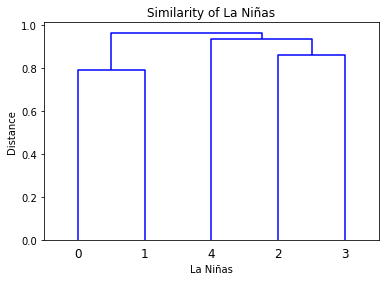

[]

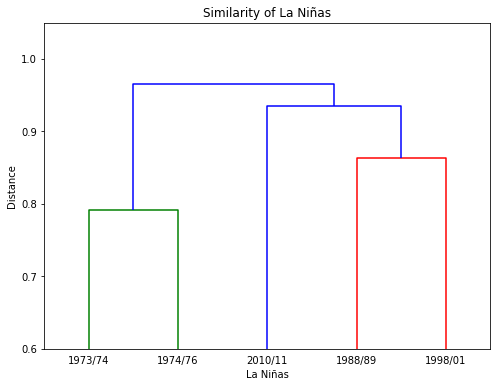

In [21]:
# in this step we take the upper triangle of the distance matrix via squareform, which will be the input for our linkage function
# this will link ElNions that are similar
# after linking the elNinos we plot the dendrogram to get a more visual understanding of the process


y= squareform(laNinaSimilarityDf)
linkage = sch.linkage(y, method='complete')
sch.dendrogram(linkage)
plt.title('Similarity of La Niñas')
plt.xlabel('La Niñas')
plt.ylabel('Distance')
plt.show()


fig = plt.figure(figsize=(8, 6))
y = squareform(laNinaSimilarityDf)
linkage = sch.linkage(y, method='complete')
sch.dendrogram(linkage, color_threshold = 0.9)
plt.title('Similarity of La Niñas')
plt.xlabel('La Niñas')
plt.ylabel('Distance')
plt.ylim((0.6, 1.05))
plt.xticks([5,15,25,35,45],['1973/74','1974/76', '2010/11', '1988/89', '1998/01'],  fontsize=10)
plt.plot()
#plt.savefig("plots/dendrogramLNTop10.svg")


#### Cross Validation For Similarity Analysis of La Niñas

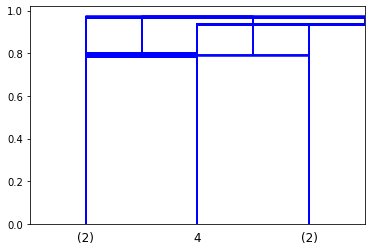

In [22]:
# Warning: This might take some time!

'''
To check the robustness of the similarity analysis we perform crossValidation on this analysis 
5 % of the samples are removed and the similarity analysis is performed to check if this impacts our results
'''
percentageToRemove = 0.05
crossValidMatrixLN = np.zeros((5,5))
dendrogramDf = pd.DataFrame(crossValidMatrixLN, columns=[0,1,2,3,4], index=[0,1,2,3,4])
amountOfSamplesToRemove = int (percentageToRemove * ds.shape[0]) # Remove 5% of the samples
topN = 10

for i in range (100): 
    ds_sub = ds.copy()
    drop_indices = np.random.choice(ds_sub.index, amountOfSamplesToRemove, replace=False)
    df_subset = ds_sub.drop(drop_indices)
    
    
    gsim1973_74 = getTopNStationsInferred(topN, activeLaNinaTime_1973_74, df_subset)
    gsim1974_76 = getTopNStationsInferred(topN, activeLaNinaTime_1974_76, df_subset)
    gsim1988_89 = getTopNStationsInferred(topN, activeLaNinaTime_1988_89, df_subset)
    gsim1998_01 = getTopNStationsInferred(topN, activeLaNinaTime_1998_01, df_subset)
    gsim2010_11 = getTopNStationsInferred(topN, activeLaNinaTime_2010_11, df_subset)

    gsimNumsDuringAllLaNinas = [gsim1973_74, gsim1974_76, gsim1988_89, gsim1998_01, gsim2010_11 ]
    similarityMatrixLaNina = np.zeros((5,5))
    for index_i, laNina_i in enumerate(gsimNumsDuringAllLaNinas): 
        for index_j, laNina_j in enumerate(gsimNumsDuringAllLaNinas): 
            similarityMatrixLaNina[index_i, index_j] = jaccardDistance(laNina_i, laNina_j)

    laNinaSimilarityDf = pd.DataFrame(similarityMatrixLaNina, columns=['1973/74', '1974/76', '1988/89', '1998/01', '2010/11'], index=['1973/74', '1974/76', '1988/89', '1998/01', '2010/11'])
    
    y = squareform(laNinaSimilarityDf)
    linkage = sch.linkage(y, method='complete')
    dn1 = sch.dendrogram(linkage)
    dn2 = sch.dendrogram(linkage, color_threshold = 0.90, truncate_mode='lastp', p=3)
    
    index = 0
    for group in dn2['ivl']:
        if group == '0' or group == '1' or group == '2' or group == '3' or group == '4':
            e1 = int (dn1['ivl'][index])
            crossValidMatrixLN[e1][e1] += 1
            index += 1
        
        elif group == '(2)':
            e1 = int (dn1['ivl'][index]) 
            e2 = int (dn1['ivl'][index +1])
            crossValidMatrixLN[e1][e2] += 1
            crossValidMatrixLN[e2][e1] += 1
            index += 2
        elif group == '(3)':
            e1 = int (dn1['ivl'][index]) 
            e2 = int (dn1['ivl'][index +1])
            e3 = int (dn1['ivl'][index +2])
            crossValidMatrixLN[e1][e2] += 1
            crossValidMatrixLN[e1][e3] += 1
            crossValidMatrixLN[e2][e1] += 1
            crossValidMatrixLN[e2][e3] += 1
            crossValidMatrixLN[e3][e1] += 1
            crossValidMatrixLN[e3][e2] += 1
            index += 3
        else:
            continue


In [23]:
crossValidMatrixLN

array([[  0., 100.,   0.,   0.,   0.],
       [100.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0., 100.,   0.],
       [  0.,   0., 100.,   0.,   0.],
       [  0.,   0.,   0.,   0., 100.]])

[]

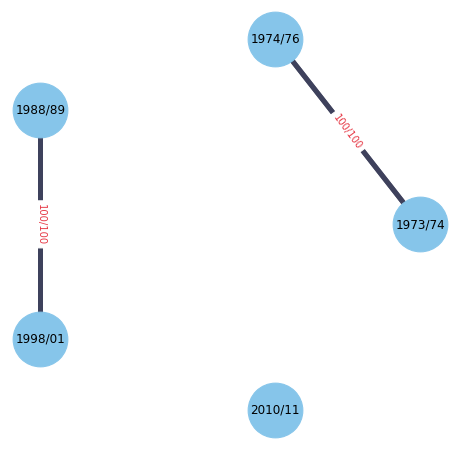

In [28]:
# The previously computed crossValidationMatrix is now used as a adjacency matrix to plot a weighted, undirected graph. 
# This graph is generated in this cell. 

# Note the values are written by hand on the edges 
# As the crossvalidation process is based on random sampling this crossValidationMatrix might look different for multiple runs
# Therefore the edge weights might differ as well and need to be adjusted manually

LNs = ['1973/74', '1974/76', '1988/89', '1998/01', '2010/11']
weights=[]

plt.figure(figsize=(8,8)) 
G = nx.MultiGraph()
G.add_nodes_from(LNs)
for indexI, row in enumerate(crossValidMatrixLN): 
    for indexJ, value in enumerate(row):
        weight=value/100
        weights.append(weight)
        G.add_edge (LNs[indexI], LNs[indexJ], weight=weight)

pos = nx.circular_layout(G)  # positions for all nodes
    
edges = G.edges(data=True)
elarge = [(u, v, d) for (u, v, d) in edges if d["weight"] > 0.45]
esmall = [(u, v, d) for (u, v, d) in edges if d["weight"]!= 0 and d["weight"] <= 0.45]

#edges
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=1, alpha=0.9, edge_color="black", style="dotted")
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=5, alpha=0.9, edge_color="#3d405b")
nx.draw_networkx_edge_labels(G,pos,edge_labels={('1973/74','1974/76'):'100/100', ('1988/89','1998/01'):'100/100' }, font_color='#e63946')


nx.draw_networkx_nodes(G, pos, with_labels=True, node_color = "#86c5ea", width=weights, node_size=3000)
nx.draw_networkx_labels(G,pos)

plt.axis("off")
plt.plot()
#plt.savefig("plots/CrossValidLNFivePercentTop10.svg")

In [25]:
elNinoColumns=['1965/66', '1972/73', '1982/83', '1997/98', '2015/16']
for index, stations in enumerate(gsimNumsDuringAllElNinos): 
    print('Number of stations affected during EN period of {0}: {1}'.format(elNinoColumns[index],len(stations)) )

Number of stations affected during EN period of 1965/66: 350
Number of stations affected during EN period of 1972/73: 180
Number of stations affected during EN period of 1982/83: 1051
Number of stations affected during EN period of 1997/98: 359
Number of stations affected during EN period of 2015/16: 198


In [26]:
laNinaColumns=['1973/74', '1974/76', '1988/89', '1998/01', '2010/11']
for index, stations in enumerate(gsimNumsDuringAllLaNinas): 
    print('Number of stations affected during LN period of {0}: {1}'.format(laNinaColumns[index],len(stations)) )

Number of stations affected during LN period of 1973/74: 317
Number of stations affected during LN period of 1974/76: 218
Number of stations affected during LN period of 1988/89: 359
Number of stations affected during LN period of 1998/01: 505
Number of stations affected during LN period of 2010/11: 148
